In [2]:
import warnings
warnings.filterwarnings("ignore")
from shapely import wkt
import glob


%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj
%matplotlib inline

import skimage

from tqdm import tqdm
import numpy as np
import cv2
from functools import partial

from fastai.imports import *
from fastai.vision import *
from fastai.metrics import dice
from fastai.callbacks import *

from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    """Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"

from catalyst.contrib.criterion import FocalLossMultiClass, DiceLoss, BCEDiceLoss, LovaszLossBinary,LovaszLossMultiClass

from importlib import reload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj


In [3]:
data_dir = Path("/media/wwymak/Storage/xView2")
mask_dir = data_dir /"mask_full_size"
models_path = data_dir / "models"
train_images_crops = data_dir/"train_crops"
mask_dir_edt = data_dir /"mask_full_size_edt"
train_mask_crops = data_dir/"mask_crops_single_channel"
label_dir = data_dir/"train"/"labels"
mask_crops_edt = data_dir/"mask_crops_edt"

In [40]:
data_dir = Path("/media/wwymak/Storage/xView2")
models_path = data_dir / "models"
classifcation_crop_dir = data_dir/"classification_crops_post"
classification_labels = pd.read_csv(data_dir/"train_pre_post.csv")
classification_labels["crop_filename"] = classification_labels.uuid.apply(lambda x: f"{x}.png")
damage_crops_test_folder = data_dir / "classification_crops_test"
classification_labels.head()

,uuid,img_id_pre,img_id_post,label,crop_filename
0,93d0ff06-ab71-45d9-9ace-6f7d86d5d5d8,palu-tsunami_00000024_pre_disaster.png,palu-tsunami_00000024_post_disaster.png,0,93d0ff06-ab71-45d9-9ace-6f7d86d5d5d8.png
1,437988fc-fb7e-4b0e-8ccf-403015a737b3,palu-tsunami_00000024_pre_disaster.png,palu-tsunami_00000024_post_disaster.png,0,437988fc-fb7e-4b0e-8ccf-403015a737b3.png
2,63d78637-7c40-40c7-a1b3-55152a64415a,palu-tsunami_00000024_pre_disaster.png,palu-tsunami_00000024_post_disaster.png,0,63d78637-7c40-40c7-a1b3-55152a64415a.png
3,31ccdff0-b7f7-4884-8e55-d35e4d2c1770,palu-tsunami_00000024_pre_disaster.png,palu-tsunami_00000024_post_disaster.png,0,31ccdff0-b7f7-4884-8e55-d35e4d2c1770.png
4,67fdaa2a-3d1f-4c7d-a63b-f08a4a4cb05b,palu-tsunami_00000024_pre_disaster.png,palu-tsunami_00000024_post_disaster.png,0,67fdaa2a-3d1f-4c7d-a63b-f08a4a4cb05b.png


In [5]:
classification_labels.label.value_counts()

0    120419
1     14980
2     14161
3     13227
Name: label, dtype: int64

In [61]:
def is_valid_func(fname, valid_ids):
    
    img_id = Path(fname).name.replace('rgb_', '').split('.')[0]
    print(img_id)

    return img_id in valid_ids

def get_mask_fn(fname):
    return train_mask_crops / fname.name.replace("rgb", "mask")

def to_onehot(indices, num_classes):
    """Convert a tensor of indices of any shape `(N, ...)` to a
    tensor of one-hot indicators of shape `(N, num_classes, ...) and of type uint8. Output's device is equal to the
    input's device`.
    """
    onehot = torch.zeros(indices.shape[0], num_classes, *indices.shape[1:],
#                              dtype=torch.uint8,
                         device=indices.device)
    return onehot.scatter_(1, indices.unsqueeze(1), 1)
class CombinedLoss(nn.Module):

    def __init__(self, gamma=2., alpha=0.25):
        super(CombinedLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, input, target, **kwargs):
        y = to_onehot(target, input.size(-1))
        logit = F.softmax(input)
                     
        focal_loss = FocalLossMultiClass(gamma=self.gamma, alpha=self.alpha)
        
        total_loss = focal_loss(logit, target) #+ 0.2 * dice_loss(logit, y)
        return total_loss
    
def f1(y_pred:Tensor, y_true:Tensor):
    eps=1e-10
    def recall(y_pred,y_true):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = torch.sum(torch.round(torch.clamp(y_true * y_pred, 0, 1)))
        possible_positives = torch.sum(y_true)
        recall = true_positives / (possible_positives + eps)
        return recall

    def precision(y_pred,y_true):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = torch.sum(torch.round(torch.clamp(y_true * y_pred, 0, 1)))
        predicted_positives = torch.sum(torch.round(torch.clamp(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives +eps)
        return precision

    y_true = to_onehot(y_true.view(-1), num_classes=4)
    precision = precision(y_pred,y_true)
    recall = recall(y_pred,y_true)
    return 2*((precision*recall)/(precision+recall+eps))#

In [34]:
unique_img_ids_undamaged= list(set([x.name.replace('mask_', '').split('.')[0] for x in train_mask_crops.ls() if 'pre' in x.name ]))
unique_img_ids_damaged= list(set([x.name.replace('mask_', '').split('.')[0] for x in train_mask_crops.ls() if 'post' in x.name ]))

print(len(unique_img_ids_damaged), len(unique_img_ids_undamaged))

np.random.seed(42)
np.random.shuffle(unique_img_ids_undamaged)
train_ids_undamaged = unique_img_ids_undamaged[:int(0.8 * len(unique_img_ids_undamaged))]
valid_ids_undamaged = unique_img_ids_undamaged[int(0.8 * len(unique_img_ids_undamaged)):]

train_ids_damaged = [x.replace('pre', 'post') for x in train_ids_undamaged]
valid_ids_damaged =[x.replace('pre', 'post') for x in valid_ids_undamaged]

print(len(train_ids_damaged), len(valid_ids_damaged))

2283 2283
1826 457


In [59]:
valid_ids_damaged[:5]

['hurricane-michael_00000541_post_disaster',
 'palu-tsunami_00000167_post_disaster',
 'socal-fire_00001268_post_disaster',
 'santa-rosa-wildfire_00000093_post_disaster',
 'midwest-flooding_00000024_post_disaster']

In [63]:
classification_labels["is_valid"] = classification_labels.img_id_post.apply(lambda x: x.replace('.png', '') in valid_ids_damaged)

In [65]:
classification_labels["is_valid"].value_counts(normalize=True)

False    0.772151
True     0.227849
Name: is_valid, dtype: float64

In [66]:
datasets= []
classification_labels_0 = classification_labels[classification_labels.label==0].sample(frac=1.)
label_0_per_bag = 20000

for i in range(0, len(classification_labels_0) , label_0_per_bag):
    datasets.append(pd.concat([
        classification_labels[(classification_labels.label!= 0)],
        classification_labels[(classification_labels.label==0)][i: i+label_0_per_bag]
    ]).reset_index(drop=True))


In [67]:
for dataset in datasets:
    valset_len = dataset[dataset.is_valid==True].shape[0]
    dataset_len = len(dataset)
    print(f"dataset has {valset_len/dataset_len *100}% validation")

dataset has 22.019363318693298% validation
dataset has 25.406341166287312% validation
dataset has 24.354823197512264% validation
dataset has 22.352771455134164% validation
dataset has 22.684576667842144% validation
dataset has 21.29804763889334% validation
dataset has 22.376314408886657% validation


In [49]:
datasets[0]

,uuid,img_id_pre,img_id_post,label,crop_filename
0,b7f18d58-1dc5-4c35-b77e-323d4eb08f8e,hurricane-matthew_00000005_pre_disaster.png,hurricane-matthew_00000005_post_disaster.png,2,b7f18d58-1dc5-4c35-b77e-323d4eb08f8e.png
1,f9d70ffb-1cff-42ad-8ae4-5cd025c5f6df,hurricane-matthew_00000005_pre_disaster.png,hurricane-matthew_00000005_post_disaster.png,2,f9d70ffb-1cff-42ad-8ae4-5cd025c5f6df.png
2,c47fdb93-fd1d-4104-b919-b64890c445d3,hurricane-matthew_00000005_pre_disaster.png,hurricane-matthew_00000005_post_disaster.png,1,c47fdb93-fd1d-4104-b919-b64890c445d3.png
3,4ed00b10-e3f3-4175-b3e2-f65b5ed3eada,hurricane-matthew_00000005_pre_disaster.png,hurricane-matthew_00000005_post_disaster.png,1,4ed00b10-e3f3-4175-b3e2-f65b5ed3eada.png
4,b9be07ec-fec9-409b-9990-921151be00f7,hurricane-matthew_00000005_pre_disaster.png,hurricane-matthew_00000005_post_disaster.png,1,b9be07ec-fec9-409b-9990-921151be00f7.png
...,...,...,...,...,...
62381,1a4ab78c-bc19-4dbc-a35e-6ed477db5bfa,mexico-earthquake_00000024_pre_disaster.png,mexico-earthquake_00000024_post_disaster.png,0,1a4ab78c-bc19-4dbc-a35e-6ed477db5bfa.png
62382,1ac9b3ff-a08f-4cf1-91df-dd6622646494,mexico-earthquake_00000024_pre_disaster.png,mexico-earthquake_00000024_post_disaster.png,0,1ac9b3ff-a08f-4cf1-91df-dd6622646494.png
62383,1ce824ec-19fa-4dd7-aa28-3cd41f11f08c,mexico-earthquake_00000024_pre_disaster.png,mexico-earthquake_00000024_post_disaster.png,0,1ce824ec-19fa-4dd7-aa28-3cd41f11f08c.png
62384,1f6f3ed4-2d01-4aa8-ba4b-2df6555b03ec,mexico-earthquake_00000024_pre_disaster.png,mexico-earthquake_00000024_post_disaster.png,0,1f6f3ed4-2d01-4aa8-ba4b-2df6555b03ec.png


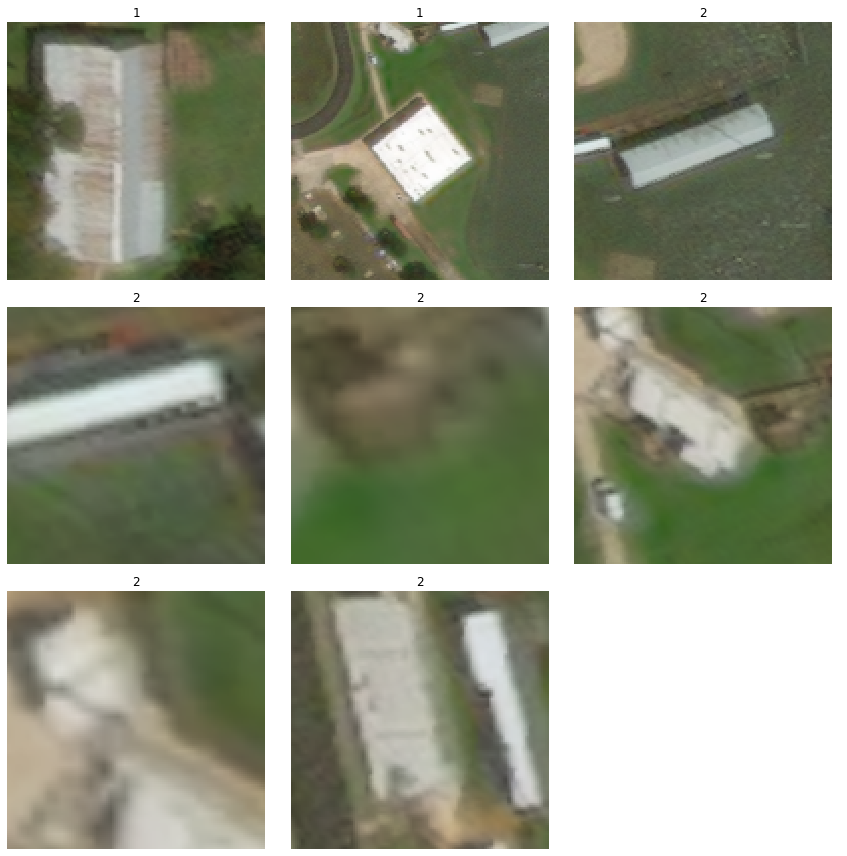

In [69]:
data.show_batch(ds_type=DatasetType.Valid)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


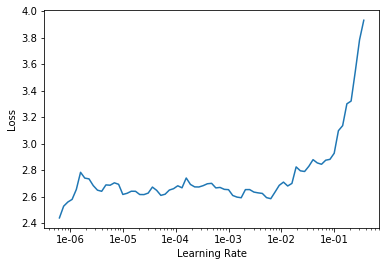

In [86]:
del learn
gc.collect()

# import geffnet
# mixnet = geffnet.mixnet_l(pretrained=True, drop_rate=0.25, drop_connect_rate=0.2, as_sequential=True)

size=128
bs=8
src = (ImageList
       .from_df(datasets[0], path=classifcation_crop_dir, cols=['crop_filename'])
       .split_from_df(col="is_valid")
       .label_from_df(cols='label'))
data = (src
        .transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=False)
        .add_test_folder(damage_crops_test_folder)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

learn = cnn_learner(data,models.resnet50, metrics=[accuracy, f1])
learn.model_dir = models_path
# learn.loss_func =CombinedLoss(alpha=0.75, gamma=4);
learn.to_fp16();

learn.lr_find()
learn.recorder.plot();


In [87]:
learn.fit_one_cycle(3, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,f1,time
0,1.063022,0.916438,0.620587,0.590515,12:33
1,0.904099,0.827959,0.672927,0.666537,03:36
2,0.815360,0.717455,0.719953,0.696825,04:46


In [54]:
data.train_ds

LabelList (62386 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
2,2,1,1,1
Path: /media/wwymak/Storage/xView2/classification_crops_post